In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, optim
from torchvision import datasets, transforms

import zipfile

import shutil
import os
import pandas as pd

device = ("cuda" if torch.cuda.is_available() else "cpu") # Use GPU or CPU for training

In [2]:
class AlexNet(nn.Module):

    def __init__(self, num_classes: int = 2):
        super(AlexNet, self).__init__()

        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.linear = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = self.convolutional(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return torch.softmax(x, 1)

In [3]:
model = AlexNet()
model = model.to(device)

In [4]:
'''with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")'''

'with zipfile.ZipFile("celeba.zip","r") as zip_ref:\n  zip_ref.extractall("data_faces/")'

In [5]:

root = '/home/luser/autoencoder_attacks/train_aautoencoders/data_faces/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

202599


In [6]:

df = pd.read_csv("/home/luser/autoencoder_attacks/train_aautoencoders/list_attr_celeba.csv")
df = df[['image_id', 'Male']]

In [7]:
df
#get all the row titles
df.index
# get all the column titles
df.columns

Index(['image_id', 'Male'], dtype='object')

In [9]:
# to make directories

'''!rm -rf data
!mkdir data && mkdir data/male && mkdir data/no_male'''

'!rm -rf data\n!mkdir data && mkdir data/male && mkdir data/no_male'

In [9]:

s0 = 0
s1 = 0

num = 1000000

for i, (_, i_row) in enumerate(df.iterrows()):
  if s0 < num:
    if i_row['Male'] == 1:
      s0 += 1
      shutil.copyfile('/home/luser/autoencoder_attacks/train_aautoencoders/data_faces/img_align_celeba/' + i_row['image_id'], 'data/male/' + i_row['image_id'])
  
  if s1 < num:
    if i_row['Male'] == -1:
      s1 += 1
      shutil.copyfile('/home/luser/autoencoder_attacks/train_aautoencoders/data_faces/img_align_celeba/' + i_row['image_id'], 'data/no_male/' + i_row['image_id'])
  
  if s0 == num and s1 == num:
    break

In [8]:

img_list = os.listdir('data/male/')
img_list.extend(os.listdir('data/no_male/'))

In [9]:
print("Images: ", len(img_list))


Images:  202599


In [10]:

transform = transforms.Compose([
          transforms.Resize((64, 64)),
          transforms.ToTensor()
          ])

batch_size = 64
celeba_data = datasets.ImageFolder('data', transform=transform)

In [11]:
print(celeba_data.classes)
print(len(celeba_data))

['male', 'no_male']
202599


In [75]:

train_set, test_set = torch.utils.data.random_split(celeba_data, [int(len(img_list) * 0.75), len(img_list) - int(len(img_list) * 0.75)])
train_data_size = len(train_set)
test_data_size = len(test_set)

In [99]:
trainLoader = torch.utils.data.DataLoader(train_set,batch_size=batch_size, shuffle=True)
testLoader  = torch.utils.data.DataLoader(test_set, batch_size=50650, shuffle=True)

In [100]:
print(train_data_size)
print(test_data_size)

151949
50650


In [15]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [18]:
epochs = 10
train_loss = []

for epoch in range(epochs):
   
    total_train_loss = 0
    
    # training our model
    for idx, (image, label) in enumerate(trainLoader):
        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()
        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)

    print(f'Epoch: {epoch} | Train Loss: {total_train_loss}')

Epoch: 0 | Train Loss: 0.40827546765929773
Epoch: 1 | Train Loss: 0.3710144022389462
Epoch: 2 | Train Loss: 0.3649670090047937
Epoch: 3 | Train Loss: 0.3606458044805025
Epoch: 4 | Train Loss: 0.35701302197105006
Epoch: 5 | Train Loss: 0.3538848352808701
Epoch: 6 | Train Loss: 0.35223924461163975
Epoch: 7 | Train Loss: 0.3504576661712245
Epoch: 8 | Train Loss: 0.3498131885905015
Epoch: 9 | Train Loss: 0.34826573493606167


In [19]:
#torch.save(model.state_dict(), '/home/luser/robustness_of_subgroups/saved_gender_classifier/gender_classifier.torch')

In [133]:
# load the saved model
model = AlexNet().to(device)
model.load_state_dict(torch.load('/home/luser/robustness_of_subgroups/saved_gender_classifier/gender_classifier.torch'))

<All keys matched successfully>

In [17]:
plt.plot(train_loss)


NameError: name 'train_loss' is not defined

In [117]:
testiter = iter(testLoader)
images, labels = next(testiter)

with torch.no_grad():
  images, labels = images.to(device), labels.to(device)
  pred = model(images)

images_np = [i.cpu() for i in images]
class_names = celeba_data.classes

KeyboardInterrupt: 

In [49]:
class_names # 0 indicates male, 1 indicates female

['male', 'no_male']

In [59]:


# Predicted class indices
predictions = np.argmax(pred.cpu().numpy(), 1)

# Actual labels (on CUDA, so we need to move it to CPU and convert to numpy)

labels_np = labels.cpu().numpy()

check = predictions == labels_np

male_indices = np.where(predictions == 1)[0]
female_indices = np.where(predictions == 1)[0]
print(female_indices)
print(check)
# Calculate the number of correct predictions
correct_predictions = np.sum(predictions == labels_np)

print(correct_predictions)

# Calculate accuracy
accuracy = correct_predictions / len(labels)

print(f"Accuracy: {accuracy:.4f}")


[ 1  2  3  5  6  7  8  9 10 12 13 14 15 16 22 24 25 26 28 29 32 34 36 37
 39 40 44 46 50 52 53 54 56 57 59 60]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True  True  True  True  True  True  True  True
  True  True  True  True]
61
Accuracy: 0.9531


In [104]:
with torch.no_grad():
  total_correct_predictions = 0
  for images, labels in testLoader:
    images, labels = images.to(device), labels.to(device)
    pred = model(images)

    predictions = np.argmax(pred.cpu().numpy(), 1)
    labels_np = labels.cpu().numpy()
    correct_predictions = np.sum(predictions == labels_np)

    accuracy = correct_predictions / len(labels)

    male_indices = np.where(labels_np == 0)[0]
    female_indices = np.where(labels_np == 1)[0]

    separated_male_labels = labels_np[male_indices]
    separated_female_labels = labels_np[female_indices]

    total_male_labels = len(separated_male_labels)
    total_female_labels = len(separated_female_labels)

    separated_male_predictions = predictions[male_indices]
    separated_female_predictions = predictions[female_indices]

    correct_male_predictions = np.sum(separated_male_labels==separated_male_predictions)
    correct_female_predictions = np.sum(separated_female_labels == separated_female_predictions)



    num_male_labeled_predictions = len(predictions[predictions==0])
    num_female_labeled_predictions = len(predictions[predictions==1])



    num_of_females_wrongly_classified_as_males = num_female_labeled_predictions - correct_female_predictions
    num_of_males_wrongly_classified_as_females = num_male_labeled_predictions - correct_male_predictions





    total_samples = len(labels)
    print()
    print("total_samples", total_samples)
    print()
    print("total_male_labels", total_male_labels)
    print("total_female_labels", total_female_labels)
    print()
    print("correct_predictions", correct_predictions)
    print()
    print(f"Accuracy: {accuracy:.4f}")
    print()
    print("correct_male_predictions", correct_male_predictions)
    print("correct_female_predictions", correct_female_predictions)
    print()
    print("num_male_labeled_predictions", num_male_labeled_predictions)
    print("female_labeled_predictions", num_female_labeled_predictions)
    print()
    print("num_of_females_wrongly_classified_as_males", num_of_females_wrongly_classified_as_males)
    print("num_of_males_wrongly_classified_as_females", num_of_males_wrongly_classified_as_females)
    print()
    print("percentage males misclassified", (num_of_males_wrongly_classified_as_females/total_male_labels)*100)
    print()
    print("percentage females misclassified", (num_of_females_wrongly_classified_as_males/total_female_labels)*100)



    break





total_samples 50650

total_male_labels 21026
total_female_labels 29624

correct_predictions 48919

Accuracy: 0.9658

correct_male_predictions 20262
correct_female_predictions 28657

num_male_labeled_predictions 21229
female_labeled_predictions 29421

num_of_females_wrongly_classified_as_males 764
num_of_males_wrongly_classified_as_females 967

percentage males misclassified 4.599067820793303

percentage females misclassified 2.578990008101539


In [54]:
accuracy

0.984375

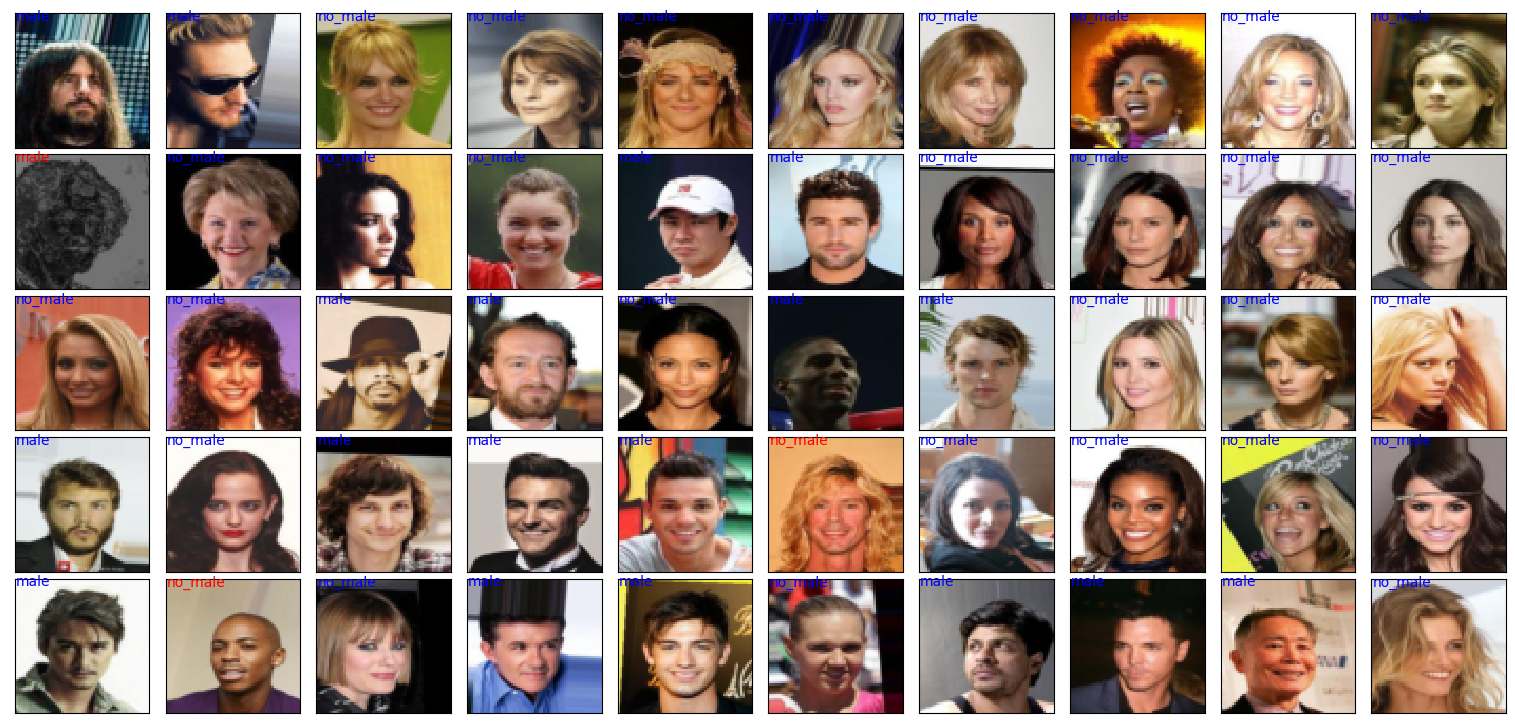

In [48]:

fig = plt.figure(figsize=(15, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(images_np[i].permute(1, 2, 0), cmap=plt.cm.gray_r, interpolation='nearest')

    if labels[i] == torch.max(pred[i], 0)[1]:
      ax.text(0, 3, class_names[torch.max(pred[i], 0)[1]], color='blue')
    else:
      ax.text(0, 3, class_names[torch.max(pred[i], 0)[1]], color='red')

# Perform the same analysis on attacked samples

In [173]:
#device = ("cuda:0" if torch.cuda.is_available() else "cpu") # Use GPU or CPU for training

from vae import VAE_big

model_vae = VAE_big(device, image_channels=3).to(device)

train_data_size = 162079
epochs = 199

beta_value = 5.0


# Attacking Vanilla VAE 

In [174]:
# 0
beta_value = 1.0

if (beta_value == 5.0 or beta_value == 10.0):
    model_vae.load_state_dict(torch.load('/home/luser/autoencoder_attacks/saved_celebA/checkpoints/celebA_CNN_VAE'+str(beta_value)+'_big_trainSize'+str(train_data_size)+'_epochs'+str(epochs)+'.torch'))
else:
    model.load_state_dict(torch.load('/home/luser/autoencoder_attacks/saved_celebA/checkpoints/celebA_CNN_VAE_big_trainSize'+str(train_data_size)+'_epochs'+str(epochs)+'.torch'))

model_vae.eval()

#segment = 14
prev_div_min = 100.0
prev_div_max = 0.0
all_losses = []

#all_features = ["youngmen", "oldmen", "youngwomen", "oldwomen"]
#all_features = ["youngmen", "youngwomen"]
#all_features = ["youngmen", "oldwomen"]
#all_features = ["oldmen", "youngwomen"]
#all_features = [ "oldmen", "oldwomen"]
#all_features = ["youngmen"]
#all_features = ["oldmen"]
#all_features = ["youngwomen"]
all_features = ["oldwomen"]


#feature = all_features[3]

all_source_images = torch.tensor([]).to(device)
all_div_outputs = torch.tensor([]).to(device)

for feature in all_features:
    for segment in range(60):
        desired_norm_l_inf = 0.094

        #all_features = ["bald", "beard", "oldfemaleGlass", "hat"]#, "generalWhiteWomen", "blackWomen"]

        universal_features_list = ["bald", "beard", "oldfemaleGlass", "hat", "blackWomen", "generalWhiteWomen", "blackMen", "generalWhiteMen", "men", "women", "young", "old", "youngmen", "oldmen", "youngwomen", "oldwomen" ]



        source_im = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/images.pt")[segment].unsqueeze(0).to(device) 
        optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/"+str(feature)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 



        image_height, image_width, _ = source_im[0].cpu().detach().permute(1, 2, 0).cpu().numpy().shape
        aspect_ratio = image_width / image_height

        corresponding_class_polulations = [1819, 24707, 145, 2827]
        #inside_feature_name = inside_feature_names[3]



        actualOutput, _, _ = model_vae(source_im)
        ActualReconLoss = torch.sqrt((actualOutput - source_im)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()


        DivAttackeImage = source_im + optimized_noise
        NormalDivAttackeImage = (DivAttackeImage - DivAttackeImage.min())/(DivAttackeImage.max() - DivAttackeImage.min())
        DivOutput,_,_ = model_vae(NormalDivAttackeImage)
        DivOutputL2ActualOutput = torch.sqrt((DivOutput - actualOutput)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

        all_losses.append(DivOutputL2ActualOutput.item())

        all_source_images = torch.cat((all_source_images, source_im))
        all_div_outputs = torch.cat((all_div_outputs, DivOutput))
        

if(all_features=="oldwomen" or all_features=="youngwomen"):
    adv_samp_labels = torch.ones(60).to(device)
if(all_features=="youngmen" or all_features=="oldmen"):
    adv_samp_labels = torch.zeros(60).to(device)


RuntimeError: Error(s) in loading state_dict for AlexNet:
	Missing key(s) in state_dict: "convolutional.0.weight", "convolutional.0.bias", "convolutional.3.weight", "convolutional.3.bias", "convolutional.6.weight", "convolutional.6.bias", "convolutional.8.weight", "convolutional.8.bias", "convolutional.10.weight", "convolutional.10.bias", "linear.1.weight", "linear.1.bias", "linear.4.weight", "linear.4.bias", "linear.6.weight", "linear.6.bias". 
	Unexpected key(s) in state_dict: "encoder.0.weight", "encoder.0.bias", "encoder.2.weight", "encoder.2.bias", "encoder.4.weight", "encoder.4.bias", "encoder.6.weight", "encoder.6.bias", "encoder.8.weight", "encoder.8.bias", "encoder.10.weight", "encoder.10.bias", "encoder.12.weight", "encoder.12.bias", "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias", "fc3.weight", "fc3.bias", "decoder.1.weight", "decoder.1.bias", "decoder.3.weight", "decoder.3.bias", "decoder.5.weight", "decoder.5.bias", "decoder.7.weight", "decoder.7.bias", "decoder.9.weight", "decoder.9.bias", "decoder.11.weight", "decoder.11.bias", "decoder.13.weight", "decoder.13.bias". 

## Vanilla VAE accuracy when not attacked

In [171]:
with torch.no_grad():
    images, labels = all_source_images.to(device), adv_samp_labels.to(device)
    pred = model(images)
    predictions = np.argmax(pred.cpu().numpy(), 1)
    labels_np = labels.cpu().numpy()
    correct_predictions = np.sum(predictions == labels_np)

    accuracy = correct_predictions / len(labels)

    male_indices = np.where(labels_np == 0)[0]
    female_indices = np.where(labels_np == 1)[0]

    separated_male_labels = labels_np[male_indices]
    separated_female_labels = labels_np[female_indices]

    total_male_labels = len(separated_male_labels)
    total_female_labels = len(separated_female_labels)

    separated_male_predictions = predictions[male_indices]
    separated_female_predictions = predictions[female_indices]

    correct_male_predictions = np.sum(separated_male_labels==separated_male_predictions)
    correct_female_predictions = np.sum(separated_female_labels == separated_female_predictions)



    num_male_labeled_predictions = len(predictions[predictions==0])
    num_female_labeled_predictions = len(predictions[predictions==1])



    num_of_females_wrongly_classified_as_males = num_female_labeled_predictions - correct_female_predictions
    num_of_males_wrongly_classified_as_females = num_male_labeled_predictions - correct_male_predictions





    total_samples = len(labels)
    print()
    print("total_samples", total_samples)
    print()
    print("total_male_labels", total_male_labels)
    print("total_female_labels", total_female_labels)
    print()
    print("correct_predictions", correct_predictions)
    print()
    print(f"Accuracy: {accuracy:.4f}")
    print()
    print("correct_male_predictions", correct_male_predictions)
    print("correct_female_predictions", correct_female_predictions)
    print()
    print("num_male_labeled_predictions", num_male_labeled_predictions)
    print("female_labeled_predictions", num_female_labeled_predictions)
    print()
    print("num_of_females_wrongly_classified_as_males", num_of_females_wrongly_classified_as_males)
    print("num_of_males_wrongly_classified_as_females", num_of_males_wrongly_classified_as_females)
    print()
    print("percentage males misclassified", (num_of_males_wrongly_classified_as_females/total_male_labels)*100)
    print()
    print("percentage females misclassified", (num_of_females_wrongly_classified_as_males/total_female_labels)*100)


total_samples 60

total_male_labels 0
total_female_labels 60

correct_predictions 54

Accuracy: 0.9000

correct_male_predictions 0
correct_female_predictions 54

num_male_labeled_predictions 6
female_labeled_predictions 54

num_of_females_wrongly_classified_as_males 0
num_of_males_wrongly_classified_as_females 6

percentage males misclassified inf

percentage females misclassified 0.0


/tmp/ipykernel_2852826/441742023.py:59: RuntimeWarning: divide by zero encountered in scalar divide
  print("percentage males misclassified", (num_of_males_wrongly_classified_as_females/total_male_labels)*100)


# Vanilla vae attack neutralized outputs prediction accuracy

In [167]:
with torch.no_grad():
    images, labels = all_div_outputs.to(device), adv_samp_labels.to(device)
    pred = model(images)
    predictions = np.argmax(pred.cpu().numpy(), 1)
    labels_np = labels.cpu().numpy()
    correct_predictions = np.sum(predictions == labels_np)

    accuracy = correct_predictions / len(labels)

    male_indices = np.where(labels_np == 0)[0]
    female_indices = np.where(labels_np == 1)[0]

    separated_male_labels = labels_np[male_indices]
    separated_female_labels = labels_np[female_indices]

    total_male_labels = len(separated_male_labels)
    total_female_labels = len(separated_female_labels)

    separated_male_predictions = predictions[male_indices]
    separated_female_predictions = predictions[female_indices]

    correct_male_predictions = np.sum(separated_male_labels==separated_male_predictions)
    correct_female_predictions = np.sum(separated_female_labels == separated_female_predictions)



    num_male_labeled_predictions = len(predictions[predictions==0])
    num_female_labeled_predictions = len(predictions[predictions==1])



    num_of_females_wrongly_classified_as_males = total_female_labels - correct_female_predictions
    num_of_males_wrongly_classified_as_females = total_male_labels - correct_male_predictions





    total_samples = len(labels)
    print()
    print("total_samples", total_samples)
    print()
    print("total_male_labels", total_male_labels)
    print("total_female_labels", total_female_labels)
    print()
    print("correct_predictions", correct_predictions)
    print()
    print(f"Accuracy: {accuracy:.4f}")
    print()
    print("correct_male_predictions", correct_male_predictions)
    print("correct_female_predictions", correct_female_predictions)
    print()
    print("num_male_labeled_predictions", num_male_labeled_predictions)
    print("female_labeled_predictions", num_female_labeled_predictions)
    print()
    print("num_of_females_wrongly_classified_as_males", num_of_females_wrongly_classified_as_males)
    print("num_of_males_wrongly_classified_as_females", num_of_males_wrongly_classified_as_females)
    print()
    print("percentage males misclassified", (num_of_males_wrongly_classified_as_females/total_male_labels)*100)
    print()
    print("percentage females misclassified", (num_of_females_wrongly_classified_as_males/total_female_labels)*100)


total_samples 60

total_male_labels 0
total_female_labels 60

correct_predictions 47

Accuracy: 0.7833

correct_male_predictions 0
correct_female_predictions 47

num_male_labeled_predictions 13
female_labeled_predictions 47

num_of_females_wrongly_classified_as_males 13
num_of_males_wrongly_classified_as_females 0

percentage males misclassified nan

percentage females misclassified 21.666666666666668


/tmp/ipykernel_2852826/3476843644.py:59: RuntimeWarning: invalid value encountered in scalar divide
  print("percentage males misclassified", (num_of_males_wrongly_classified_as_females/total_male_labels)*100)


# Attacking Beta VAE beta = 5.0

In [168]:
# 0
beta_value = 5.0
model_vae.load_state_dict(torch.load('/home/luser/autoencoder_attacks/saved_celebA/checkpoints/celebA_CNN_VAE'+str(beta_value)+'_big_trainSize'+str(train_data_size)+'_epochs'+str(epochs)+'.torch'))

model_vae.eval()

#segment = 14
prev_div_min = 100.0
prev_div_max = 0.0
all_losses = []

#all_features = ["youngmen", "oldmen", "youngwomen", "oldwomen"]
#all_features = ["youngmen", "youngwomen"]
#all_features = ["youngmen", "oldwomen"]
#all_features = ["oldmen", "youngwomen"]
#all_features = [ "oldmen", "oldwomen"]
#all_features = ["youngmen"]
#all_features = ["oldmen"]
#all_features = ["youngwomen"]
all_features = ["oldwomen"]


#feature = all_features[3]

all_source_images = torch.tensor([]).to(device)
all_div_outputs = torch.tensor([]).to(device)

for feature in all_features:
    for segment in range(60):
        desired_norm_l_inf = 0.094

        #all_features = ["bald", "beard", "oldfemaleGlass", "hat"]#, "generalWhiteWomen", "blackWomen"]

        universal_features_list = ["bald", "beard", "oldfemaleGlass", "hat", "blackWomen", "generalWhiteWomen", "blackMen", "generalWhiteMen", "men", "women", "young", "old", "youngmen", "oldmen", "youngwomen", "oldwomen" ]



        source_im = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/images.pt")[segment].unsqueeze(0).to(device) 
        optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/"+str(feature)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 



        image_height, image_width, _ = source_im[0].cpu().detach().permute(1, 2, 0).cpu().numpy().shape
        aspect_ratio = image_width / image_height

        corresponding_class_polulations = [1819, 24707, 145, 2827]
        #inside_feature_name = inside_feature_names[3]



        actualOutput, _, _ = model_vae(source_im)
        ActualReconLoss = torch.sqrt((actualOutput - source_im)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()


        DivAttackeImage = source_im + optimized_noise
        NormalDivAttackeImage = (DivAttackeImage - DivAttackeImage.min())/(DivAttackeImage.max() - DivAttackeImage.min())
        DivOutput,_,_ = model_vae(NormalDivAttackeImage)
        DivOutputL2ActualOutput = torch.sqrt((DivOutput - actualOutput)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

        all_losses.append(DivOutputL2ActualOutput.item())

        all_source_images = torch.cat((all_source_images, source_im))
        all_div_outputs = torch.cat((all_div_outputs, DivOutput))
        

adv_samp_labels = torch.ones(60).to(device)


In [169]:
with torch.no_grad():
    images, labels = all_source_images.to(device), adv_samp_labels.to(device)
    pred = model(images)
    predictions = np.argmax(pred.cpu().numpy(), 1)
    labels_np = labels.cpu().numpy()
    correct_predictions = np.sum(predictions == labels_np)

    accuracy = correct_predictions / len(labels)

    male_indices = np.where(labels_np == 0)[0]
    female_indices = np.where(labels_np == 1)[0]

    separated_male_labels = labels_np[male_indices]
    separated_female_labels = labels_np[female_indices]

    total_male_labels = len(separated_male_labels)
    total_female_labels = len(separated_female_labels)

    separated_male_predictions = predictions[male_indices]
    separated_female_predictions = predictions[female_indices]

    correct_male_predictions = np.sum(separated_male_labels==separated_male_predictions)
    correct_female_predictions = np.sum(separated_female_labels == separated_female_predictions)



    num_male_labeled_predictions = len(predictions[predictions==0])
    num_female_labeled_predictions = len(predictions[predictions==1])



    num_of_females_wrongly_classified_as_males = num_female_labeled_predictions - correct_female_predictions
    num_of_males_wrongly_classified_as_females = num_male_labeled_predictions - correct_male_predictions





    total_samples = len(labels)
    print()
    print("total_samples", total_samples)
    print()
    print("total_male_labels", total_male_labels)
    print("total_female_labels", total_female_labels)
    print()
    print("correct_predictions", correct_predictions)
    print()
    print(f"Accuracy: {accuracy:.4f}")
    print()
    print("correct_male_predictions", correct_male_predictions)
    print("correct_female_predictions", correct_female_predictions)
    print()
    print("num_male_labeled_predictions", num_male_labeled_predictions)
    print("female_labeled_predictions", num_female_labeled_predictions)
    print()
    print("num_of_females_wrongly_classified_as_males", num_of_females_wrongly_classified_as_males)
    print("num_of_males_wrongly_classified_as_females", num_of_males_wrongly_classified_as_females)
    print()
    print("percentage males misclassified", (num_of_males_wrongly_classified_as_females/total_male_labels)*100)
    print()
    print("percentage females misclassified", (num_of_females_wrongly_classified_as_males/total_female_labels)*100)


total_samples 60

total_male_labels 0
total_female_labels 60

correct_predictions 54

Accuracy: 0.9000

correct_male_predictions 0
correct_female_predictions 54

num_male_labeled_predictions 6
female_labeled_predictions 54

num_of_females_wrongly_classified_as_males 0
num_of_males_wrongly_classified_as_females 6

percentage males misclassified inf

percentage females misclassified 0.0


/tmp/ipykernel_2852826/441742023.py:59: RuntimeWarning: divide by zero encountered in scalar divide
  print("percentage males misclassified", (num_of_males_wrongly_classified_as_females/total_male_labels)*100)


In [159]:
with torch.no_grad():
    images, labels = all_div_outputs.to(device), adv_samp_labels.to(device)
    pred = model(images)
    predictions = np.argmax(pred.cpu().numpy(), 1)
    labels_np = labels.cpu().numpy()
    correct_predictions = np.sum(predictions == labels_np)

    accuracy = correct_predictions / len(labels)

    male_indices = np.where(labels_np == 0)[0]
    female_indices = np.where(labels_np == 1)[0]

    separated_male_labels = labels_np[male_indices]
    separated_female_labels = labels_np[female_indices]

    total_male_labels = len(separated_male_labels)
    total_female_labels = len(separated_female_labels)

    separated_male_predictions = predictions[male_indices]
    separated_female_predictions = predictions[female_indices]

    correct_male_predictions = np.sum(separated_male_labels==separated_male_predictions)
    correct_female_predictions = np.sum(separated_female_labels == separated_female_predictions)



    num_male_labeled_predictions = len(predictions[predictions==0])
    num_female_labeled_predictions = len(predictions[predictions==1])



    num_of_females_wrongly_classified_as_males = total_female_labels - correct_female_predictions
    num_of_males_wrongly_classified_as_females = total_male_labels - correct_male_predictions





    total_samples = len(labels)
    print()
    print("total_samples", total_samples)
    print()
    print("total_male_labels", total_male_labels)
    print("total_female_labels", total_female_labels)
    print()
    print("correct_predictions", correct_predictions)
    print()
    print(f"Accuracy: {accuracy:.4f}")
    print()
    print("correct_male_predictions", correct_male_predictions)
    print("correct_female_predictions", correct_female_predictions)
    print()
    print("num_male_labeled_predictions", num_male_labeled_predictions)
    print("female_labeled_predictions", num_female_labeled_predictions)
    print()
    print("num_of_females_wrongly_classified_as_males", num_of_females_wrongly_classified_as_males)
    print("num_of_males_wrongly_classified_as_females", num_of_males_wrongly_classified_as_females)
    print()
    print("percentage males misclassified", (num_of_males_wrongly_classified_as_females/total_male_labels)*100)
    print()
    print("percentage females misclassified", (num_of_females_wrongly_classified_as_males/total_female_labels)*100)


total_samples 60

total_male_labels 0
total_female_labels 60

correct_predictions 47

Accuracy: 0.7833

correct_male_predictions 0
correct_female_predictions 47

num_male_labeled_predictions 13
female_labeled_predictions 47

num_of_females_wrongly_classified_as_males 13
num_of_males_wrongly_classified_as_females 0

percentage males misclassified nan

percentage females misclassified 21.666666666666668


/tmp/ipykernel_2852826/3476843644.py:59: RuntimeWarning: invalid value encountered in scalar divide
  print("percentage males misclassified", (num_of_males_wrongly_classified_as_females/total_male_labels)*100)
